In [156]:
!pip install progressbar2

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [157]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
from random import shuffle
import progressbar
import cv2

def load_data():
    
    path = './'
    pctr1 = os.path.join(path,'data_class1_train.npy')
    pctr2 = os.path.join(path,'data_class2_train.npy')
    pctr3 = os.path.join(path,'data_class3_train.npy')
    pcte1 = os.path.join(path,'data_class1_test.npy')
    pcte2 = os.path.join(path,'data_class2_test.npy')
    pcte3 = os.path.join(path,'data_class3_test.npy')
    
    
    train1 = np.load(pctr1)
    train2 = np.load(pctr2)
    train3 = np.load(pctr3)
    test1 = np.load(pcte1)
    test2 = np.load(pcte2)
    test3 = np.load(pcte3)
    
    return train1, train2, train3, test1, test2, test3

In [176]:
def get_predictions(x, mu, cov, pi, prior):
    sum_g = np.ndarray(shape=(x.shape[0],1),dtype=float)
    for i in range(x.shape[0]):
        for j in range(1):
            sum_g[i][j]=0
            
    l = len(cov)
    for i in range(l):
        
        cov2 = np.ndarray(shape=(cov[i].shape[0],cov[i].shape[0]), dtype=float)
        cov2 = np.copy(cov[i])
        for w in range(cov[i].shape[0]):
            for z in range(cov[i].shape[0]):
                if(w!=z):
                    cov2[w][z]=1e-5
                else:
                    cov2[w][z]+=1e-3
            
        temp = pi[i]*(np.linalg.det(cov2)**-.5)* np.exp(-.5 * np.einsum('ij, ij -> i',x - mu[i],np.matmul(np.linalg.inv(cov2),(x- mu[i]).T).T))
        temp = np.reshape(temp,(x.shape[0],1))
        sum_g+=temp
    return sum_g*prior

In [177]:
def get_confusion_mat(c1, c2, c3, classes):
    
    lis = []
    if(c3!=0):
        conf_mat = np.full((3,3),1e-10)
        for i in range(c1):
            lis.append(0)
        for i in range(c2):
            lis.append(1)
        for i in range(c3):
            lis.append(2)
        for i in range(len(classes)):
            conf_mat[lis[i]][classes[i]]+=1
        return np.array(conf_mat)
    else:
        conf_mat = np.full((2,2),1e-10)
        for i in range(c1):
            lis.append(0)
        for i in range(c2):
            lis.append(1)
        for i in range(len(classes)):
            conf_mat[lis[i]][classes[i]]+=1

        return np.array(conf_mat)

In [178]:
def metric(conf_matrix):
    x = conf_matrix.shape[0]
    precision = []
    accuracy = []
    recall = []
    f_measure = []
    total_sum = np.sum(conf_matrix)
    for i in range(x):
        TP = conf_matrix[i][i]
        FN = np.sum(conf_matrix[i,:])-conf_matrix[i][i]
        FP = np.sum(conf_matrix[:,i])-conf_matrix[i][i]
        TN = total_sum-(TP+FP+FN)

        recal = TP/(TP+FN)
        preci = TP/(TP+FP)
        acc = (TP+TN)/(TP+TN+FP+FN)
        
        precision.append(preci)
        recall.append(recal)
        accuracy.append(acc)
        f_measure.append((2*recal*preci)/(recal+preci))
        
    return accuracy,precision,recall,f_measure

In [179]:
def pair_plot(test1, test2, dc1, dc2, mu1, cov1, pi1, mu2, cov2, pi2, il, jl,k):
    le1 = dc1.shape[0]
    le2 = dc2.shape[0]
    le  = le1+le2
    
    g1 = []
    g2 = []
    lw1 = test1.shape[0]
    lw2 = test2.shape[0]

    p1 = get_predictions(test1, mu1, cov1, pi1, le1/le)
    p2 = get_predictions(test1, mu2, cov2, pi2, le2/le)
    for i in progressbar.progressbar(range(lw1)):
        g1.append(p1[i][0])
        g2.append(p2[i][0])
    p1 = get_predictions(test2, mu1, cov1, pi1, le1/le)
    p2 = get_predictions(test2, mu2, cov2, pi2, le2/le)
    for i in progressbar.progressbar(range(lw2)):
        g1.append(p1[i][0])
        g2.append(p2[i][0])


    classes = []
    lw = lw1+lw2
    for i in progressbar.progressbar(range(lw)):
        classes.append(np.argmax([g1[i],g2[i]]))

    conf_mat = get_confusion_mat(lw1, lw2, 0, classes)
    print("Confusion Matrix")
    print(conf_mat)
    temp = np.array(metric(conf_mat))
    print("Accuracy: ",temp[0,:])
    print("Precision: ",temp[1,:])
    print("Recall: ",temp[2,:])
    print("F-Measure: ",temp[3,:])
    print("Mean F-Measure: ",np.mean(temp[3,:]))
    print("Mean F-Measure: ",np.mean(temp[3,:]))

In [180]:
def total_plot(test1, test2, test3, train1, train2, train3, mu1, cov1, pi1, mu2, cov2, pi2, mu3, cov3, pi3,k):
    le1 = train1.shape[0]
    le2 = train2.shape[0]
    le3 = train3.shape[0]
    le  = le1+le2+le3
    
    g1 = []
    g2 = []
    g3 = []
    lw1 = test1.shape[0]
    lw2 = test2.shape[0]
    lw3 = test3.shape[0]

    p1 = get_predictions(test1, mu1, cov1, pi1, le1/le)
    p2 = get_predictions(test1, mu2, cov2, pi2, le2/le)
    p3 = get_predictions(test1, mu3, cov3, pi3, le3/le)
    for i in progressbar.progressbar(range(lw1)):
        g1.append(p1[i][0])
        g2.append(p2[i][0])
        g3.append(p3[i][0])
    p1 = get_predictions(test2, mu1, cov1, pi1, le1/le)
    p2 = get_predictions(test2, mu2, cov2, pi2, le2/le)
    p3 = get_predictions(test2, mu3, cov3, pi3, le3/le)
    for i in progressbar.progressbar(range(lw2)):
        g1.append(p1[i][0])
        g2.append(p2[i][0])
        g3.append(p3[i][0])
    p1 = get_predictions(test3, mu1, cov1, pi1, le1/le)
    p2 = get_predictions(test3, mu2, cov2, pi2, le2/le)
    p3 = get_predictions(test3, mu3, cov3, pi3, le3/le)
    for i in progressbar.progressbar(range(lw3)):
        g1.append(p1[i][0])
        g2.append(p2[i][0])
        g3.append(p3[i][0])



    classes = []
    lw = lw1+lw2+lw3
    for i in range(lw):
        classes.append(np.argmax([g1[i],g2[i],g3[i]]))

    conf_mat = get_confusion_mat(lw1, lw2, lw3, classes)
    print(conf_mat)
    temp = np.array(metric(conf_mat))
    print("Accuracy: ",temp[0,:])
    print("Precision: ",temp[1,:])
    print("Recall: ",temp[2,:])
    print("F-Measure: ",temp[3,:])
    print("Mean F-Measure: ",np.mean(temp[3,:]))

In [181]:
def gaussian_normal(x, mu, cov):
    
    cov2 = np.copy(cov)
    for w in range(cov.shape[0]):
        for z in range(cov.shape[0]):
            if(w!=z):
                cov2[w][z]=1e-5
            else:
                cov2[w][z]+=1e-3
    
    g = (np.linalg.det(cov2)**-.5)*((2 * np.pi)**(-x.shape[1]/2.))* np.exp(-.5 * np.einsum('ij, ij -> i',x - mu,np.dot(np.linalg.inv(cov2),(x- mu).T).T)) 
    return g

def gmm(cluster, pts, k, dims):
    mu = []                    #mean of each cluster
    cov = []                   #covaraince matrix for each cluster
    pi =  []                   #mixture coefficients for each clusters
    n = len(pts)               #total number of points in the given class
    gamma = np.ndarray(shape=(n,k),dtype=float)
    for i in range(k):
        pi.append(cluster[i].shape[0]/n)
        mean = np.mean(cluster[i], axis=0)
        mu.append(mean)
        covariance = np.cov(cluster[i].T)
        cov.append(covariance)
    
    
    likelihood = []
    for t in progressbar.progressbar(range(100)):
        for j in range(k):
            gamma[:,j] = pi[j]*gaussian_normal(pts,mu[j],cov[j])
        li = np.sum(np.log(np.sum(gamma, axis = 1)))
        likelihood.append(li)
        gamma = (gamma.T / np.sum(gamma, axis = 1)).T
        n_eff = np.sum(gamma, axis = 0)
        for i in range(k):
            mu[i] = (1/n_eff[i])*np.sum(gamma[:, i] * pts.T, axis = 1).T
            x_mu = np.matrix(pts - mu[i])
            cov[i] = np.array(1/n_eff[i])*np.matmul(np.multiply(x_mu.T,  gamma[:, i]), x_mu)
            pi[i] = n_eff[i]/n
    
    plt.plot(likelihood)
    plt.title('Log-Likelihood vs Iteration plot')
    plt.xlabel('Iterations')
    plt.ylabel('log-likelihood')
    plt.show()

    return mu, cov, pi, gamma

In [182]:
def find_dist(x,mu):
    return ((x[0]-mu[0])*(x[0]-mu[0])+(x[0]-mu[0])*(x[0]-mu[0]))**0.5
def kmeans(data,k, dim):
    
    l = data.shape[0]
    lis = []
    for i in range(l):
        lis.append(data[i,:])
    
    shuffle(lis)
    cluster = []
    mean = []
    for i in range(k):
        mean.append(lis[i])
        
    for i in progressbar.progressbar(range(500)):
        cluster[:]=[]
        
        distance=[]
        clust=[]
        for j in range(l):
            distance.append(1e15)
            clust.append(-1)
        for j in range(k):
            temp=[]
            cluster.append(temp)
        for j in range(k):
            dis = np.linalg.norm(data-mean[j], axis=1)
            for p in range(l):
                if(dis[p]<distance[p]):
                    distance[p]=dis[p]
                    clust[p] = j
                    
        for j in range(l):
            cluster[clust[j]].append(data[j])
        for j in range(k):
            if(len(cluster[j])==0):
                num = random.randint(0,l-1)
                cluster[j].append(data[num])
                num = random.randint(0,l-1)
                cluster[j].append(data[num])
            if(len(cluster[j])==1):
                num = random.randint(0,l-1)
                cluster[j].append(data[num])
        
        for j in range(k):
            mean[j]=np.mean(cluster[j], axis=0)
            
            
    for i in (range(k)):
        cluster[i]=np.array(cluster[i])
        
    return mean, cluster

In [183]:
def get_bow(path, train, mean):
    kernal = 32
    lis = []
    prevl = 0
    for im in progressbar.progressbar(os.listdir(path)):
        image = cv2.imread(os.path.join(path,im))
        padx = (32-int(image.shape[0]%kernal))%kernal
        pady = (32-int(image.shape[1]%kernal))%kernal
        x = int((image.shape[0]+padx)/kernal)
        y = int((image.shape[1]+pady)/kernal)
        bins = x*y
        lis.append(bins+prevl)
        prevl+=bins
        
      
    bow = np.ndarray(shape=(len(lis),32), dtype=float)
    for i in range(len(lis)):
        for j in range(32):
            bow[i][j]=0
    bn = 0
    ln = 0
    
    distance=[]
    clust=[]
    l=train.shape[0]
    for j in range(l):
        distance.append(1e15)
        clust.append(-1)
    for j in range(32):
        dis = np.linalg.norm(train-mean[j], axis=1)
        for p in range(l):
            if(dis[p]<distance[p]):
                distance[p]=dis[p]
                clust[p] = j
    
    for i in range(l):
        if(i==lis[ln]):
            bn+=1
            ln+=1
        bow[bn][clust[i]]+=1
    
    return bow

 10% (5 of 49) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

Mean Calculated


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 32% (16 of 50) |#######                 | Elapsed Time: 0:00:00 ETA:   0:00:00

Train 1 BOvW Calcualted


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 16% (8 of 50) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

Train 2 BOvW Calcualted


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 20% (10 of 50) |####                    | Elapsed Time: 0:00:00 ETA:   0:00:00

Train 3 BOvW Calcualted


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 14% (7 of 50) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

Test 1 BOvW Calcualted


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 10% (5 of 50) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02

Test 2 BOvW Calcualted


100% (50 of 50) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 71% (355 of 500) |###############       | Elapsed Time: 0:00:00 ETA:  00:00:00

Test 3 BOvW Calcualted


100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (27 of 100) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:00

kmeans done for  1


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


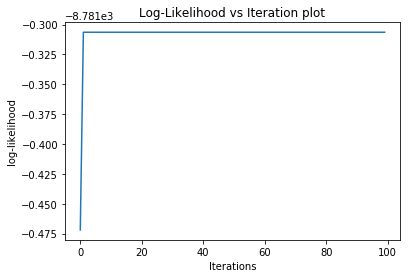

 97% (97 of 100) |###################### | Elapsed Time: 0:00:00 ETA:   0:00:00

***First Cluster Done***


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


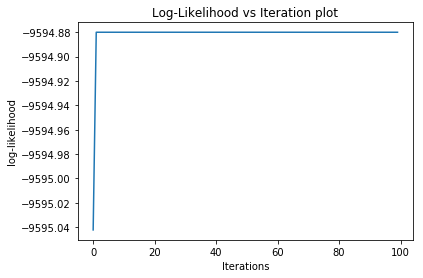

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


***Second Cluster Done***


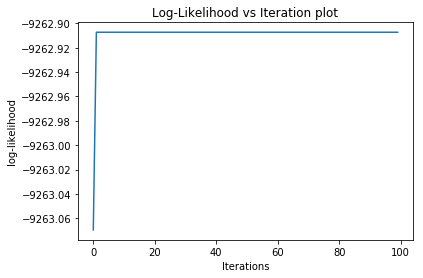

100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 500) |                       

***Third Cluster Done***
Confusion Matrix
[[ 43.   7.]
 [ 29.  21.]]
Accuracy:  [ 0.64  0.64]
Precision:  [ 0.59722222  0.75      ]
Recall:  [ 0.86  0.42]
F-Measure:  [ 0.70491803  0.53846154]
Mean F-Measure:  0.621689785624
Mean F-Measure:  0.621689785624
Confusion Matrix
[[ 38.  12.]
 [ 31.  19.]]
Accuracy:  [ 0.57  0.57]
Precision:  [ 0.55072464  0.61290323]
Recall:  [ 0.76  0.38]
F-Measure:  [ 0.63865546  0.4691358 ]
Mean F-Measure:  0.553895632327
Mean F-Measure:  0.553895632327
Confusion Matrix
[[ 12.  38.]
 [ 13.  37.]]
Accuracy:  [ 0.49  0.49]
Precision:  [ 0.48        0.49333333]
Recall:  [ 0.24  0.74]
F-Measure:  [ 0.32   0.592]
Mean F-Measure:  0.456
Mean F-Measure:  0.456
[[ 38.   4.   8.]
 [ 28.  12.  10.]
 [ 31.   9.  10.]]
Accuracy:  [ 0.52666667  0.66        0.61333333]
Precision:  [ 0.39175258  0.48        0.35714286]
Recall:  [ 0.76  0.24  0.2 ]
F-Measure:  [ 0.5170068   0.32        0.25641026]
Mean F-Measure:  0.364472353044
Cluster=====>  1 completed


100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 56% (56 of 100) |############           | Elapsed Time: 0:00:00 ETA:   0:00:00

kmeans done for  2


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


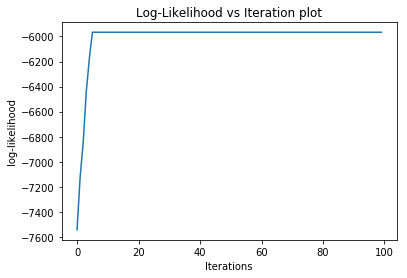

 59% (59 of 100) |#############          | Elapsed Time: 0:00:00 ETA:   0:00:00

***First Cluster Done***


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


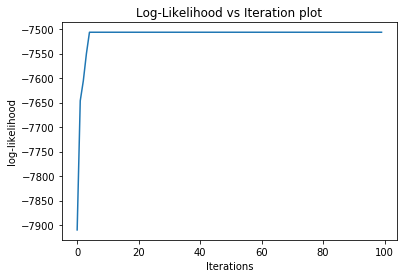

 22% (22 of 100) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:00

***Second Cluster Done***


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


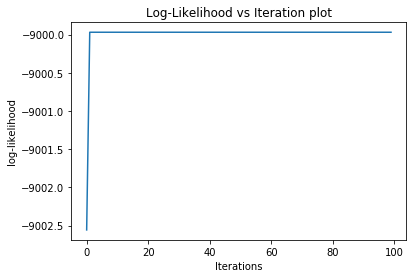

100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


***Third Cluster Done***
Confusion Matrix
[[ 37.  13.]
 [ 35.  15.]]
Accuracy:  [ 0.52  0.52]
Precision:  [ 0.51388889  0.53571429]
Recall:  [ 0.74  0.3 ]
F-Measure:  [ 0.60655738  0.38461538]
Mean F-Measure:  0.495586380832
Mean F-Measure:  0.495586380832
Confusion Matrix
[[ 32.  18.]
 [ 27.  23.]]
Accuracy:  [ 0.55  0.55]
Precision:  [ 0.54237288  0.56097561]
Recall:  [ 0.64  0.46]
F-Measure:  [ 0.58715596  0.50549451]
Mean F-Measure:  0.546325234398
Mean F-Measure:  0.546325234398


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 52% (260 of 500) |###########           | Elapsed Time: 0:00:00 ETA:   0:00:00

Confusion Matrix
[[ 35.  15.]
 [ 31.  19.]]
Accuracy:  [ 0.54  0.54]
Precision:  [ 0.53030303  0.55882353]
Recall:  [ 0.7   0.38]
F-Measure:  [ 0.60344828  0.45238095]
Mean F-Measure:  0.527914614121
Mean F-Measure:  0.527914614121
[[ 26.  13.  11.]
 [ 22.  13.  15.]
 [ 23.  10.  17.]]
Accuracy:  [ 0.54        0.6         0.60666667]
Precision:  [ 0.36619718  0.36111111  0.39534884]
Recall:  [ 0.52  0.26  0.34]
F-Measure:  [ 0.42975207  0.30232558  0.3655914 ]
Mean F-Measure:  0.365889681787
Cluster=====>  2 completed


100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:00

kmeans done for  4


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


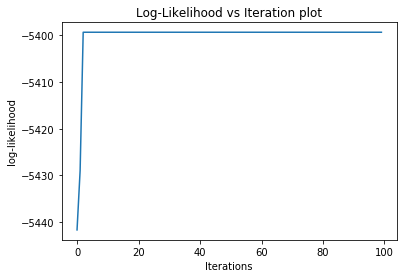

 28% (28 of 100) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:00

***First Cluster Done***


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


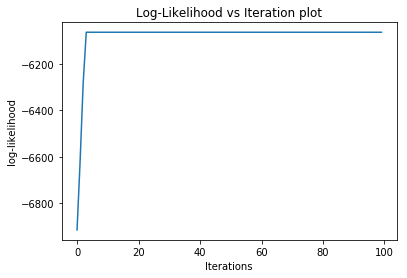

 37% (37 of 100) |########               | Elapsed Time: 0:00:00 ETA:   0:00:00

***Second Cluster Done***


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


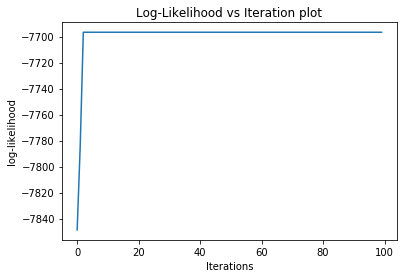

100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


***Third Cluster Done***
Confusion Matrix
[[ 25.  25.]
 [ 13.  37.]]
Accuracy:  [ 0.62  0.62]
Precision:  [ 0.65789474  0.59677419]
Recall:  [ 0.5   0.74]
F-Measure:  [ 0.56818182  0.66071429]
Mean F-Measure:  0.614448051948
Mean F-Measure:  0.614448051948
Confusion Matrix
[[ 27.  23.]
 [ 23.  27.]]
Accuracy:  [ 0.54  0.54]
Precision:  [ 0.54  0.54]
Recall:  [ 0.54  0.54]
F-Measure:  [ 0.54  0.54]
Mean F-Measure:  0.54
Mean F-Measure:  0.54
Confusion Matrix
[[ 32.  18.]
 [ 20.  30.]]
Accuracy:  [ 0.62  0.62]
Precision:  [ 0.61538462  0.625     ]
Recall:  [ 0.64  0.6 ]
F-Measure:  [ 0.62745098  0.6122449 ]
Mean F-Measure:  0.619847939175
Mean F-Measure:  0.619847939175


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 56% (285 of 500) |############          | Elapsed Time: 0:00:00 ETA:   0:00:00

[[ 17.  20.  13.]
 [  6.  29.  15.]
 [ 18.  14.  18.]]
Accuracy:  [ 0.62        0.63333333  0.6       ]
Precision:  [ 0.41463415  0.46031746  0.39130435]
Recall:  [ 0.34  0.58  0.36]
F-Measure:  [ 0.37362637  0.51327434  0.375     ]
Mean F-Measure:  0.420633569969
Cluster=====>  4 completed


100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:00

kmeans done for  8


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


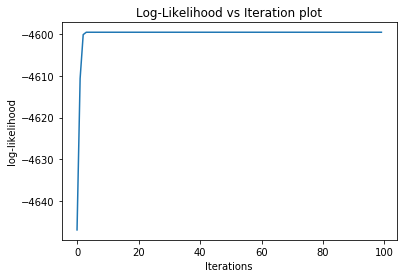

 21% (21 of 100) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

***First Cluster Done***


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


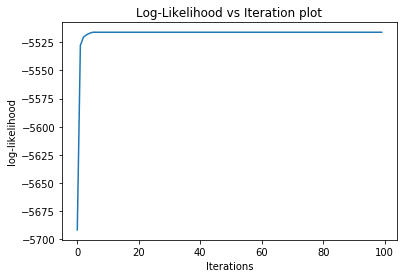

  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:10

***Second Cluster Done***


100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


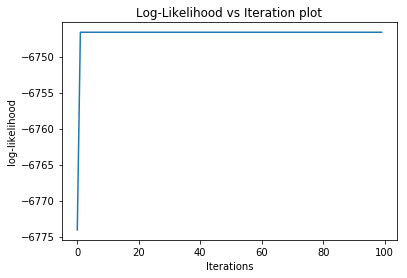

100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

***Third Cluster Done***
Confusion Matrix
[[ 21.  29.]
 [ 17.  33.]]
Accuracy:  [ 0.54  0.54]
Precision:  [ 0.55263158  0.53225806]
Recall:  [ 0.42  0.66]
F-Measure:  [ 0.47727273  0.58928571]
Mean F-Measure:  0.533279220779
Mean F-Measure:  0.533279220779
Confusion Matrix
[[ 24.  26.]
 [ 24.  26.]]
Accuracy:  [ 0.5  0.5]
Precision:  [ 0.5  0.5]
Recall:  [ 0.48  0.52]
F-Measure:  [ 0.48979592  0.50980392]
Mean F-Measure:  0.499799919968
Mean F-Measure:  0.499799919968


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  6% (32 of 500) |#                      | Elapsed Time: 0:00:00 ETA:  00:00:00

Confusion Matrix
[[ 38.  12.]
 [ 27.  23.]]
Accuracy:  [ 0.61  0.61]
Precision:  [ 0.58461538  0.65714286]
Recall:  [ 0.76  0.46]
F-Measure:  [ 0.66086957  0.54117647]
Mean F-Measure:  0.601023017902
Mean F-Measure:  0.601023017902
[[ 16.  22.  12.]
 [ 14.  27.   9.]
 [ 12.  22.  16.]]
Accuracy:  [ 0.6         0.55333333  0.63333333]
Precision:  [ 0.38095238  0.38028169  0.43243243]
Recall:  [ 0.32  0.54  0.32]
F-Measure:  [ 0.34782609  0.44628099  0.36781609]
Mean F-Measure:  0.387307723548
Cluster=====>  8 completed


100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 11% (11 of 100) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:01

kmeans done for  16


100% (100 of 100) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


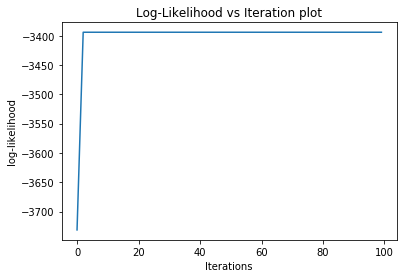

  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:10

***First Cluster Done***


100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


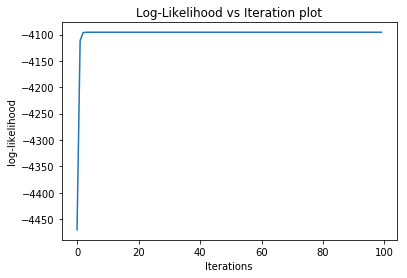

  9% (9 of 100) |##                      | Elapsed Time: 0:00:00 ETA:   0:00:01

***Second Cluster Done***


100% (100 of 100) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


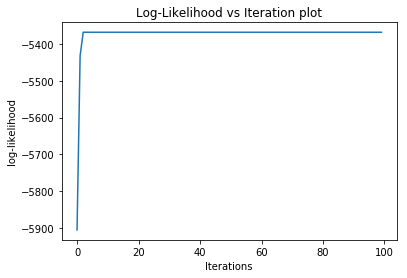

***Third Cluster Done***


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 22.  28.]
 [ 16.  34.]]
Accuracy:  [ 0.56  0.56]
Precision:  [ 0.57894737  0.5483871 ]
Recall:  [ 0.44  0.68]
F-Measure:  [ 0.5         0.60714286]
Mean F-Measure:  0.553571428571
Mean F-Measure:  0.553571428571


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Confusion Matrix
[[ 21.  29.]
 [ 12.  38.]]
Accuracy:  [ 0.59  0.59]
Precision:  [ 0.63636364  0.56716418]
Recall:  [ 0.42  0.76]
F-Measure:  [ 0.5060241   0.64957265]
Mean F-Measure:  0.577798372979
Mean F-Measure:  0.577798372979


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Confusion Matrix
[[ 33.  17.]
 [ 28.  22.]]
Accuracy:  [ 0.55  0.55]
Precision:  [ 0.54098361  0.56410256]
Recall:  [ 0.66  0.44]
F-Measure:  [ 0.59459459  0.49438202]
Mean F-Measure:  0.544488308533
Mean F-Measure:  0.544488308533


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


[[ 16.  18.  16.]
 [ 14.  27.   9.]
 [  6.  23.  21.]]
Accuracy:  [ 0.64        0.57333333  0.64      ]
Precision:  [ 0.44444444  0.39705882  0.45652174]
Recall:  [ 0.32  0.54  0.42]
F-Measure:  [ 0.37209302  0.45762712  0.4375    ]
Mean F-Measure:  0.422406713966
Cluster=====>  16 completed


In [184]:
def main():
    train1, train2, train3, test1, test2, test3 = load_data()
    K = [1,2,4,8,16]
    dims = 24
    
        
    ##Bag of visual words###
    lis = []
    for i in range(train1.shape[0]):
        lis.append(train1[i])
    for i in range(train2.shape[0]):
        lis.append(train2[i])
    for i in range(train3.shape[0]):
        lis.append(train3[i])

#     lis = np.array(lis)
#     mean, cluster = kmeans(lis, 32, 24)
#     mean = np.array(mean)
#     print(mean)
    
#     np.save('bow_kmean_mean.npy',mean)
    print('Mean Calculated')
    mean = np.load('bow_kmean_mean.npy')
#     print(mean.shape)



    path = 'dataset3/train/assembly_line'
    bow1 = get_bow(path, train1, mean)
    np.save('bow_1.npy',bow1)
    print('Train 1 BOvW Calcualted')
    
    path = 'dataset3/train/general_store_indoor'
    bow2 = get_bow(path, train2, mean)
    np.save('bow_2.npy',bow2)
    print('Train 2 BOvW Calcualted')
    
    path = 'dataset3/train/schoolhouse'
    bow3 = get_bow(path, train3, mean)
    np.save('bow_3.npy',bow3)
    print('Train 3 BOvW Calcualted')
    
    path = 'dataset3/test/assembly_line'
    bow_t1 = get_bow(path, test1, mean)
    np.save('bow_t1.npy',bow_t1)
    print('Test 1 BOvW Calcualted')
    
    path = 'dataset3/test/general_store_indoor'
    bow_t2 = get_bow(path, test2, mean)
    np.save('bow_t2.npy',bow_t2)
    print('Test 2 BOvW Calcualted')

    path = 'dataset3/test/schoolhouse'
    bow_t3 = get_bow(path, test3, mean)
    np.save('bow_t3.npy',bow_t3)
    print('Test 3 BOvW Calcualted')
    
    bow1=np.load('bow_1.npy')
    bow2=np.load('bow_2.npy')
    bow3=np.load('bow_3.npy')
    
    bow_t1=np.load('bow_t1.npy')
    bow_t2=np.load('bow_t2.npy')
    bow_t3=np.load('bow_t3.npy')
    dims = 32
    
    for k in K:
        disc = 3
        mean, cluster1 = kmeans(bow1,k,dims)
        mean, cluster2 = kmeans(bow2,k,dims)
        mean, cluster3 = kmeans(bow3,k,dims)

                
        print('kmeans done for ',k)
    

        mu1, cov1, pi1, gamma = gmm(cluster1, bow1, k, dims)
        print('***First Cluster Done***')
        mu2, cov2, pi2, gamma = gmm(cluster2, bow2, k, dims)
        print('***Second Cluster Done***')
        mu3, cov3, pi3, gamma = gmm(cluster3, bow3, k, dims)
        print('***Third Cluster Done***')

        pair_plot(bow_t1, bow_t2, bow1, bow2, mu1, cov1, pi1, mu2, cov2, pi2, 1, 2,k)

        pair_plot(bow_t1, bow_t3, bow1, bow3, mu1, cov1, pi1, mu3, cov3, pi3, 1, 3,k)
        pair_plot(bow_t2, bow_t3, bow2, bow3, mu2, cov2, pi2, mu3, cov3, pi3, 2, 3,k)
        
        
        total_plot(bow_t1, bow_t2, bow_t3, bow1, bow2, bow3, mu1, cov1, pi1, mu2, cov2, 
                   pi2, mu3, cov3, pi3,k)
#         TP = conf_matrix[i][i]
#         FN = np.sum(conf_matrix[i,:])-conf_matrix[i][i]
#         FP = np.sum(conf_matrix[:,i])-conf_matrix[i][i]
#         TN = total_sum-(TP+FP+FN)

#         recal = TP/(TP+FN)
#         preci = TP/(TP+FP)
#         acc = (TP+TN)/(TP+TN+FP+FN)
        
        print('Cluster=====> ',k, 'completed')
if(__name__=="__main__"):    
    main()    